In [5]:
import pickle

split_06_file="/data/rag/data_splits/PDBBind-DUD_E_FLAPP_0.6.pkl"
split_09_file="/data/rag/data_splits/PDBBind-DUD_E_FLAPP_0.9.pkl"


with open(split_06_file, 'rb') as f:
    split_06 = pickle.load(f)
with open(split_09_file, 'rb') as f:
    split_09 = pickle.load(f)
data_size_06 = len(split_06['train']) + len(split_06['valid'])
print("Data size for 0.6 split: ", data_size_06)
data_size_09 = len(split_09['train']) + len(split_09['valid'])
print("Data size for 0.9 split: ", data_size_09)

Data size for 0.6 split:  12344
Data size for 0.9 split:  17519


In [1]:
# draw the crossdocked dude flapp score distribution
from tqdm import tqdm
flapp_file="/data/rag/FLAPP/dude_CrossDocked_output.txt"




with open(flapp_file, 'r') as f:
    lines = f.readlines()

scores_list=[]
for line in tqdm(lines[1:]):
    result_line=line.strip().split("\t")
    scores=result_line[2].split(" ")
    matching_score=max(float(scores[3]),float(scores[4]))
    source = result_line[0].strip().split(".")[0]
    target = result_line[1].strip().split(".")[0]
    self.scores_list.append((source,target,matching_score))

In [4]:
# calc vina

import concurrent.futures
import torch
import rdkit
from rdkit import Chem
from tqdm import tqdm
import sys 
sys.path.append("/project/Pocket2Mol")
from evaluation.docking_vina import VinaDockingTask

mol_file="/data/gaobowen/tmp_mols/high_ef_pur2_4.sdf"
protein_root="/data/DUD-E/raw/pur2/receptor.pdb"


mol = Chem.SDMolSupplier(mol_file)[0]
vina_task = VinaDockingTask.from_generated_mol(
        mol, protein_root=protein_root,
        tmp_dir="/data/vina_tmp"
        )
score_only_results = vina_task.run(mode='score_only', exhaustiveness=8)
minimize_results = vina_task.run(mode='minimize', exhaustiveness=8)
print(score_only_results)

[{'affinity': -7.659, 'pose': None}]


In [5]:
# calc vina

import concurrent.futures
import torch
import rdkit
from rdkit import Chem
from tqdm import tqdm
import sys 
sys.path.append("/project/Pocket2Mol")
from evaluation.docking_vina import VinaDockingTask

mol_file="/data/DUD-E/raw/pur2/crystal_ligand.sdf"
protein_root="/data/DUD-E/raw/pur2/receptor.pdb"


mol = Chem.SDMolSupplier(mol_file)[0]
vina_task = VinaDockingTask.from_generated_mol(
        mol, protein_root=protein_root,
        tmp_dir="/data/vina_tmp"
        )
score_only_results = vina_task.run(mode='score_only', exhaustiveness=8)
minimize_results = vina_task.run(mode='minimize', exhaustiveness=8)
print(score_only_results)

[{'affinity': -8.431, 'pose': None}]


In [2]:
# calc vina

import concurrent.futures
import torch
import rdkit
from rdkit import Chem
from tqdm import tqdm
import sys 
sys.path.append("/project/Pocket2Mol")
from evaluation.docking_vina import VinaDockingTask

mol_file="/data/gaobowen/tmp_mols/high_sim_aofb.sdf"
protein_root="/data/DUD-E/raw/aofb/receptor.pdb"


mol = Chem.SDMolSupplier(mol_file)[0]
vina_task = VinaDockingTask.from_generated_mol(
        mol, protein_root=protein_root,
        tmp_dir="/data/vina_tmp"
        )
score_only_results = vina_task.run(mode='score_only', exhaustiveness=8)
minimize_results = vina_task.run(mode='minimize', exhaustiveness=8)
print(score_only_results)

[{'affinity': -6.568, 'pose': None}]


In [6]:
# draw the mol_atom_number-QED relation
# use sampled mols from bfn pdbbind09

import glob
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import QED
sdf_dir="/data/bfn_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.9"
sdf_list=glob.glob(sdf_dir+"/*.sdf")
atom_num_QED_pairs=[]

for sdf_file in tqdm(sdf_list):
    supplier = Chem.SDMolSupplier(sdf_file)
    for mol in supplier:
        qed = Chem.QED.qed(mol)
        atom_num = mol.GetNumAtoms()
        atom_num_QED_pairs.append((atom_num,qed))



  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:04<00:00, 25.12it/s]


MSE:  0.02469431453203803
R2:  0.3100838636838088


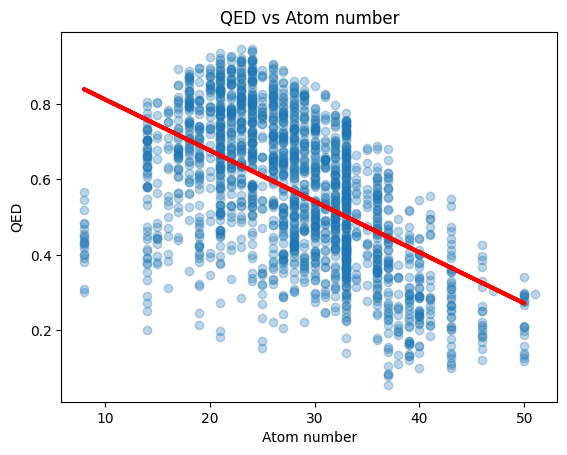

In [12]:
import matplotlib.pyplot as plt
import numpy as np
atom_num_QED_pairs = np.array(atom_num_QED_pairs)
plt.scatter(atom_num_QED_pairs[:,0],atom_num_QED_pairs[:,1],alpha=0.3)
plt.xlabel("Atom number")
plt.ylabel("QED")

# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
X = atom_num_QED_pairs[:,0].reshape(-1,1)
y = atom_num_QED_pairs[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("MSE: ",mean_squared_error(y_test,y_pred))
print("R2: ",r2_score(y_test,y_pred))
plt.plot(X_test, y_pred, color='red', linewidth=3)
plt.title("QED vs Atom number")
plt.show()


In [1]:
# define vina calculation function

import concurrent.futures
import torch
import rdkit
from rdkit import Chem
from tqdm import tqdm
import sys 
sys.path.append("/project/Pocket2Mol")
from evaluation.docking_vina import VinaDockingTask

def calc_vina(mol, protein_root):
    vina_task = VinaDockingTask.from_generated_mol(
        mol, protein_root=protein_root,
        tmp_dir="/data/vina_tmp"
        )
    try:
        score_only_results = vina_task.run(mode='score_only', exhaustiveness=8)
    except:
        return None
    return score_only_results[0]['affinity']

def calc_vina_docking(mol, protein_root):
    vina_task = VinaDockingTask.from_generated_mol(
        mol, protein_root=protein_root,
        tmp_dir="/data/vina_tmp"
        )
    try:
        docking_results = vina_task.run(mode='dock', exhaustiveness=8)
    except:
        return None
    return docking_results[0]['affinity']

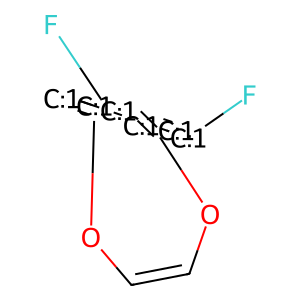

None


In [29]:
sdf_file="/data/druggps_data/DUD-E_sample_output/pretained/dyr/156.sdf"
# sdf_file="/project/ProFSA/mol.sdf"
recepter_file="/data/DUD-E_druggps/raw/dyr/receptor.pdb"
mol = Chem.SDMolSupplier(sdf_file)[0]
# draw the mol
from rdkit.Chem import Draw
img = Draw.MolToImage(mol)
img.show()
print(calc_vina_docking(mol, recepter_file))


In [39]:
# draw the mean vina of different cases

import torch

data=torch.load("/data/bfn_data/tanhaichuan_bfn_sbdd/pdbbind0.9/default/test_outputs_v3/vina_docked.pt")

ligand_vina_list={}

for item in data:
    ligand = item['ligand_filename']

    vina=item['vina']['score_only'][0]['affinity']
    # if is nan continue
    if vina!=vina:
        continue
    if ligand not in ligand_vina_list:
        ligand_vina_list[ligand]=[]
    ligand_vina_list[ligand].append(vina)

Text(0.5, 1.0, 'Vina score distribution of different ligands')

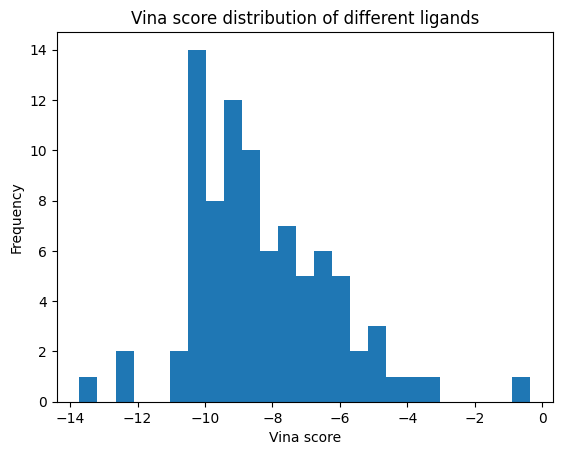

In [42]:
import numpy as np
import matplotlib.pyplot as plt

mean_vina_list=[]
for ligand in ligand_vina_list:
    mean_vina_list.append(np.mean(ligand_vina_list[ligand]))
plt.hist(mean_vina_list,bins=25)
plt.xlabel("Vina score")
plt.ylabel("Frequency")
plt.title("Vina score distribution of different ligands")


In [5]:
# calc DUDE all ground truth vina dock score

from scripts.benchmark.dataset import DUDEDataset
import rdkit
from rdkit import Chem
from tqdm import tqdm
dataset=DUDEDataset()

score_list=[]

for item in tqdm(dataset):
    mol = Chem.MolFromMol2File(item['ligand_dir'])
    print(item['ligand_dir'])
    protein_root = item['protein_dir']
    vina_dock_score = calc_vina_docking(mol, protein_root)
    if vina_dock_score is not None:
        score_list.append(vina_dock_score)
    print(vina_dock_score)

0it [00:00, ?it/s]

/data/DUD-E/raw/adrb2/crystal_ligand.mol2


1it [00:05,  5.04s/it]

-8.721
/data/DUD-E/raw/gria2/crystal_ligand.mol2


2it [00:09,  4.96s/it]

-9.835
/data/DUD-E/raw/abl1/crystal_ligand.mol2


3it [00:14,  4.88s/it]

-13.125
/data/DUD-E/raw/parp1/crystal_ligand.mol2


4it [00:19,  4.98s/it]

-10.201
/data/DUD-E/raw/dpp4/crystal_ligand.mol2


5it [00:27,  6.02s/it]

-9.909
/data/DUD-E/raw/src/crystal_ligand.mol2


6it [02:11, 39.32s/it]

-8.813
/data/DUD-E/raw/grik1/crystal_ligand.mol2


7it [02:25, 30.85s/it]

-6.973
/data/DUD-E/raw/kpcb/crystal_ligand.mol2


8it [03:54, 49.59s/it]

-9.196
/data/DUD-E/raw/reni/crystal_ligand.mol2


9it [07:27, 100.48s/it]

-10.868
/data/DUD-E/raw/kif11/crystal_ligand.mol2


10it [07:57, 78.87s/it]

-11.006
/data/DUD-E/raw/dyr/crystal_ligand.mol2


11it [07:59, 55.23s/it]

None
/data/DUD-E/raw/hivint/crystal_ligand.mol2


12it [08:11, 42.11s/it]

-6.848
/data/DUD-E/raw/adrb1/crystal_ligand.mol2


13it [08:27, 34.20s/it]

-8.621
/data/DUD-E/raw/mp2k1/crystal_ligand.mol2


14it [09:10, 37.00s/it]

-8.028
/data/DUD-E/raw/aldr/crystal_ligand.mol2


15it [09:42, 35.31s/it]

-11.732
/data/DUD-E/raw/aofb/crystal_ligand.mol2


16it [09:46, 25.96s/it]

-7.137
/data/DUD-E/raw/cp3a4/crystal_ligand.mol2


17it [11:47, 54.67s/it]

-9.118
/data/DUD-E/raw/fkb1a/crystal_ligand.mol2


18it [12:03, 43.03s/it]

-6.963
/data/DUD-E/raw/fnta/crystal_ligand.mol2


19it [12:36, 39.86s/it]

-9.072
/data/DUD-E/raw/esr2/crystal_ligand.mol2


20it [12:49, 31.92s/it]

-9.172
/data/DUD-E/raw/kit/crystal_ligand.mol2


21it [12:52, 23.23s/it]

-9.683
/data/DUD-E/raw/urok/crystal_ligand.mol2


22it [13:00, 18.71s/it]

-8.154
/data/DUD-E/raw/pygm/crystal_ligand.mol2


23it [13:07, 15.20s/it]

-9.826
/data/DUD-E/raw/hmdh/crystal_ligand.mol2


24it [13:31, 17.58s/it]

-8.445
/data/DUD-E/raw/rock1/crystal_ligand.mol2


25it [13:33, 13.08s/it]

-7.284
/data/DUD-E/raw/hivpr/crystal_ligand.mol2


26it [13:34,  9.39s/it]

None
/data/DUD-E/raw/wee1/crystal_ligand.mol2


27it [13:47, 10.36s/it]

-11.145
/data/DUD-E/raw/jak2/crystal_ligand.mol2


28it [13:56,  9.95s/it]

-10.453
/data/DUD-E/raw/hdac2/crystal_ligand.mol2


29it [14:01,  8.55s/it]

-8.945
/data/DUD-E/raw/thrb/crystal_ligand.mol2


30it [14:02,  6.23s/it]

None
/data/DUD-E/raw/pyrd/crystal_ligand.mol2


31it [14:06,  5.59s/it]

-12.048
/data/DUD-E/raw/cp2c9/crystal_ligand.mol2


32it [14:09,  4.75s/it]

None
/data/DUD-E/raw/sahh/crystal_ligand.mol2


33it [14:12,  4.32s/it]

-10.198
/data/DUD-E/raw/ampc/crystal_ligand.mol2


34it [14:13,  3.29s/it]

None
/data/DUD-E/raw/andr/crystal_ligand.mol2


35it [14:15,  3.07s/it]

-10.619
/data/DUD-E/raw/nram/crystal_ligand.mol2


36it [14:23,  4.46s/it]

-7.354
/data/DUD-E/raw/vgfr2/crystal_ligand.mol2


37it [14:36,  7.13s/it]

-11.441
/data/DUD-E/raw/braf/crystal_ligand.mol2


38it [14:43,  7.08s/it]

-10.937
/data/DUD-E/raw/glcm/crystal_ligand.mol2


39it [14:48,  6.50s/it]

-5.024
/data/DUD-E/raw/drd3/crystal_ligand.mol2


40it [14:56,  6.79s/it]

-8.591
/data/DUD-E/raw/hdac8/crystal_ligand.mol2


41it [15:01,  6.18s/it]

-7.524
/data/DUD-E/raw/hivrt/crystal_ligand.mol2


42it [15:06,  5.95s/it]

-9.983
/data/DUD-E/raw/akt2/crystal_ligand.mol2


43it [15:20,  8.38s/it]

-10.634
/data/DUD-E/raw/hxk4/crystal_ligand.mol2


44it [15:26,  7.49s/it]

-8.435
/data/DUD-E/raw/pur2/crystal_ligand.mol2


45it [15:54, 13.79s/it]

-10.173
/data/DUD-E/raw/pa2ga/crystal_ligand.mol2


46it [16:22, 17.99s/it]

-8.386
/data/DUD-E/raw/aces/crystal_ligand.mol2


47it [16:25, 13.48s/it]

-12.33
/data/DUD-E/raw/mk14/crystal_ligand.mol2


48it [16:40, 13.91s/it]

-11.192
/data/DUD-E/raw/fa7/crystal_ligand.mol2


49it [17:02, 16.45s/it]

-8.997
/data/DUD-E/raw/rxra/crystal_ligand.mol2


50it [17:13, 14.67s/it]

-8.525
/data/DUD-E/raw/plk1/crystal_ligand.mol2


51it [17:22, 13.09s/it]

-10.394
/data/DUD-E/raw/esr1/crystal_ligand.mol2


52it [17:35, 13.11s/it]

-11.805
/data/DUD-E/raw/lkha4/crystal_ligand.mol2


53it [17:36,  9.45s/it]

None
/data/DUD-E/raw/cdk2/crystal_ligand.mol2


54it [17:37,  6.88s/it]

None
/data/DUD-E/raw/igf1r/crystal_ligand.mol2


55it [17:45,  7.35s/it]

-9.129
/data/DUD-E/raw/casp3/crystal_ligand.mol2


56it [18:11, 12.73s/it]

-1.047
/data/DUD-E/raw/mapk2/crystal_ligand.mol2


57it [18:14,  9.87s/it]

None
/data/DUD-E/raw/try1/crystal_ligand.mol2


58it [20:40, 50.76s/it]

-8.589
/data/DUD-E/raw/inha/crystal_ligand.mol2


59it [21:15, 45.96s/it]

-8.739
/data/DUD-E/raw/akt1/crystal_ligand.mol2


60it [21:18, 33.19s/it]

None
/data/DUD-E/raw/pparg/crystal_ligand.mol2


61it [21:22, 24.34s/it]

None
/data/DUD-E/raw/ppard/crystal_ligand.mol2


62it [23:25, 53.92s/it]

-10.506
/data/DUD-E/raw/csf1r/crystal_ligand.mol2


63it [24:15, 52.93s/it]

-9.384
/data/DUD-E/raw/mmp13/crystal_ligand.mol2


64it [25:17, 55.55s/it]

-9.456
/data/DUD-E/raw/egfr/crystal_ligand.mol2


65it [26:47, 65.81s/it]

-10.928
/data/DUD-E/raw/mk10/crystal_ligand.mol2


66it [28:23, 74.94s/it]

-10.357
/data/DUD-E/raw/mcr/crystal_ligand.mol2


67it [28:51, 60.70s/it]

-11.879
/data/DUD-E/raw/nos1/crystal_ligand.mol2


68it [29:34, 55.61s/it]

-4.675
/data/DUD-E/raw/hs90a/crystal_ligand.mol2


69it [30:07, 48.63s/it]

-8.348
/data/DUD-E/raw/tysy/crystal_ligand.mol2


70it [31:44, 63.15s/it]

-11.678
/data/DUD-E/raw/fabp4/crystal_ligand.mol2


71it [31:47, 45.10s/it]

None
/data/DUD-E/raw/tgfr1/crystal_ligand.mol2


72it [32:14, 39.88s/it]

-11.146
/data/DUD-E/raw/ada/crystal_ligand.mol2


73it [32:50, 38.65s/it]

-9.326
/data/DUD-E/raw/fpps/crystal_ligand.mol2


74it [32:54, 28.06s/it]

None
/data/DUD-E/raw/thb/crystal_ligand.mol2


75it [33:38, 33.10s/it]

-12.565
/data/DUD-E/raw/fgfr1/crystal_ligand.mol2


76it [33:52, 27.24s/it]

-9.782
/data/DUD-E/raw/cah2/crystal_ligand.mol2


77it [33:56, 20.16s/it]

None
/data/DUD-E/raw/cxcr4/crystal_ligand.mol2


78it [34:48, 29.70s/it]

-7.404
/data/DUD-E/raw/ptn1/crystal_ligand.mol2


79it [35:06, 26.27s/it]

-6.624
/data/DUD-E/raw/pgh1/crystal_ligand.mol2


80it [36:03, 35.57s/it]

-9.347
/data/DUD-E/raw/ppara/crystal_ligand.mol2


81it [36:53, 40.00s/it]

-10.818
/data/DUD-E/raw/pde5a/crystal_ligand.mol2


[15:02:52] VIA: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
82it [36:56, 28.79s/it]

None
/data/DUD-E/raw/gcr/crystal_ligand.mol2


83it [37:43, 34.30s/it]

-13.94
/data/DUD-E/raw/bace1/crystal_ligand.mol2


84it [37:45, 24.48s/it]

None
/data/DUD-E/raw/ace/crystal_ligand.mol2


85it [41:49, 90.43s/it]

-10.599
/data/DUD-E/raw/def/crystal_ligand.mol2


86it [42:34, 76.74s/it]

-7.197
/data/DUD-E/raw/mk01/crystal_ligand.mol2


87it [42:48, 57.83s/it]

-9.268
/data/DUD-E/raw/tryb1/crystal_ligand.mol2


88it [43:03, 45.21s/it]

-9.594
/data/DUD-E/raw/pgh2/crystal_ligand.mol2


89it [43:18, 35.99s/it]

-12.19
/data/DUD-E/raw/met/crystal_ligand.mol2


90it [45:21, 62.03s/it]

-11.144
/data/DUD-E/raw/fa10/crystal_ligand.mol2


91it [45:42, 49.87s/it]

-10.965
/data/DUD-E/raw/fak1/crystal_ligand.mol2


92it [46:15, 44.91s/it]

-11.14
/data/DUD-E/raw/kith/crystal_ligand.mol2


93it [46:21, 33.01s/it]

-8.28
/data/DUD-E/raw/dhi1/crystal_ligand.mol2


94it [46:49, 31.58s/it]

-9.702
/data/DUD-E/raw/prgr/crystal_ligand.mol2


95it [46:59, 25.23s/it]

-10.157
/data/DUD-E/raw/ada17/crystal_ligand.mol2


96it [47:06, 19.66s/it]

-7.069
/data/DUD-E/raw/pnph/crystal_ligand.mol2


97it [47:12, 15.68s/it]

-7.521
/data/DUD-E/raw/ital/crystal_ligand.mol2


98it [47:35, 17.69s/it]

-10.244
/data/DUD-E/raw/comt/crystal_ligand.mol2


99it [47:38, 13.43s/it]

-5.87
/data/DUD-E/raw/xiap/crystal_ligand.mol2


100it [48:05, 17.41s/it]

-7.575
/data/DUD-E/raw/lck/crystal_ligand.mol2


101it [48:19, 16.53s/it]WARNING: At low exhaustiveness, it may be impossible to utilize all CPUs.
101it [48:19, 28.71s/it]

-8.298


In [10]:
#print mean
import numpy as np
print(np.mean(score_list))

-9.363218390804597


In [6]:
# generate mol sdf of fda dataset

import rdkit
from rdkit import Chem
import pandas as pd
from rdkit.Chem import AllChem
smiles="OC(=CF)S[C:1]1(O)[CH:1](F)[NH:1][C:1]12[CH2:2][CH2:2][CH2:2][CH2:2][NH:2]2"
# generate 10 conformations
mol_list=[]
for i in range(10):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mol_list.append(mol)
# write to sdf
writer = Chem.SDWriter("mol.sdf")
for mol in mol_list:
    writer.write(mol)
writer.close()

In [4]:
# temp

import torch
import glob
import numpy as np
import rdkit
from rdkit import Chem

result_dir=glob.glob("/data/ligan_data/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/*")
score_list=[]

for result_file in result_dir:
    data=torch.load(result_file)
    for item in data:
        mol=item['mol']
        # if multiple fragment the continue
        if len(Chem.GetMolFrags(mol))>1:
            continue
        score_list.append(item['vina_dock'])

#print mean
print(np.mean(score_list))

-5.715213261648746


/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/braf.pt 15
-15.092


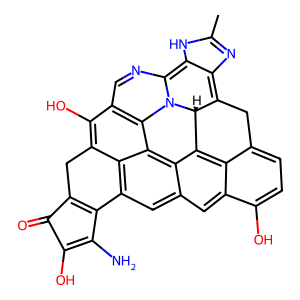

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/tgfr1.pt 9
-15.316


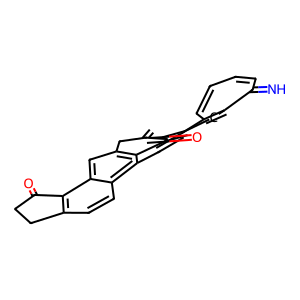

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/tgfr1.pt 10
-16.551


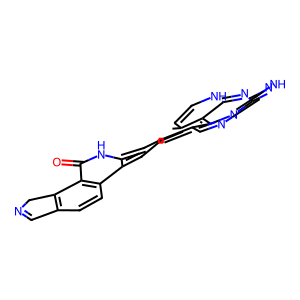

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/rxra.pt 1
-15.147


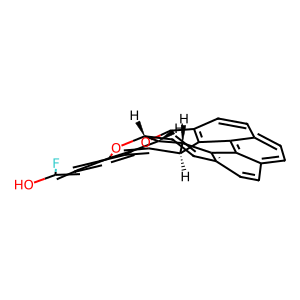

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/rxra.pt 12
-15.177


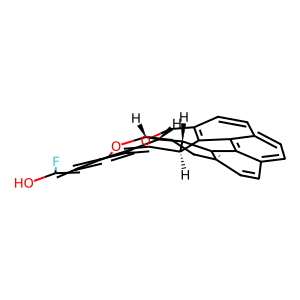

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/plk1.pt 5
-15.898


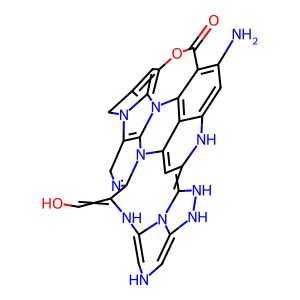

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/abl1.pt 3
-15.073


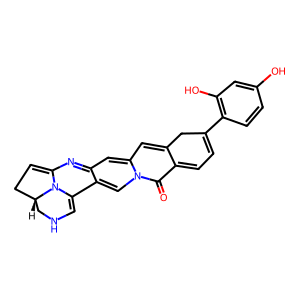

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/abl1.pt 8
-15.311


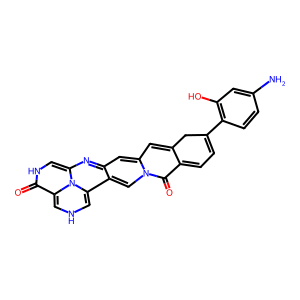

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/abl1.pt 10
-16.493


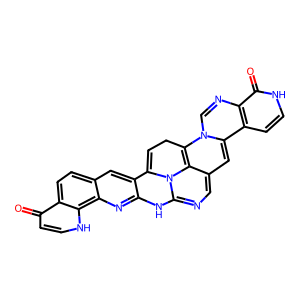

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/abl1.pt 17
-15.499


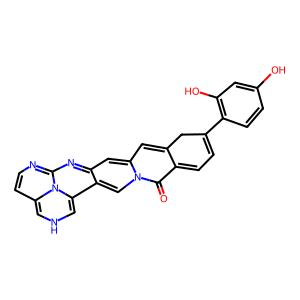

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/abl1.pt 18
-15.001


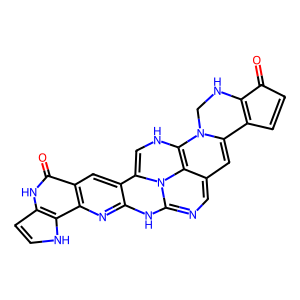

/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/abl1.pt 19
-15.502


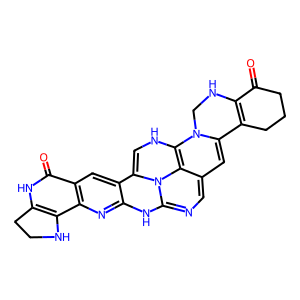

In [39]:
# find vina score bad case
import torch
import glob
import numpy as np
import rdkit
from rdkit import Chem
results=glob.glob("/data/pocket2mol_data/DUD-E_sample_output/PDBBind-DUD_E_FLAPP_0.6/vina_dock_results/*.pt")
for result_file in results:
    data=torch.load(result_file)
    for i,item in enumerate(data):
        if item['vina_dock']<-15:
            print(result_file,i)
            print(item['vina_dock'])
            # print the mol image
            mol=item['mol']
            Chem.Draw.MolToImage(mol).show()

In [6]:
# read /data/DUD-E/aa2ar/crystal_ligand.mol2
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
mol = Chem.MolFromMol2File("/data/DUD-E/raw/ada/crystal_ligand.mol2")
Chem.SanitizeMol(mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

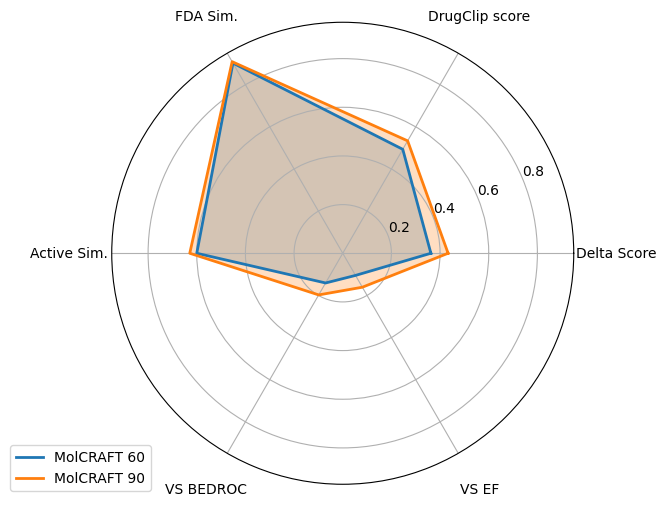

In [2]:
# draw the radar chart

import matplotlib.pyplot as plt
import numpy as np

# Metrics and data sets
labels = np.array(["Delta Score", "DrugClip score", "FDA Sim.", "Active Sim.", "VS BEDROC", "VS EF"])
max_value= [2.686,0.473,0.749,0.870,45.43,29.23]
min_value= [0,-0.2,0,0,1,1]


bfn_60=[0.973, 0.132, 0.676, 0.522, 7.265, 3.968]
bfn_90=[1.163, 0.159, 0.681, 0.547, 9.782, 5.549]


bfn_60=np.array(bfn_60)
bfn_90=np.array(bfn_90)
max_value=np.array(max_value)
min_value=np.array(min_value)
# Number of variables
num_vars = len(labels)

# Adjusting normalization factors to emphasize differences between BFN 60 and BFN 90

# Increasing normalization factor differences to make the differences more pronounced
bfn_60_normalized_adjusted = (bfn_60 - min_value) / (max_value - min_value)
bfn_90_normalized_adjusted = (bfn_90 - min_value) / (max_value - min_value)

# Compute angle for each axis
angles_adjusted = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles_adjusted += angles_adjusted[:1]

# The radar chart is a circle, so we need to complete the loop
data_adjusted = np.vstack((bfn_60_normalized_adjusted, bfn_90_normalized_adjusted))
data_adjusted = np.concatenate((data_adjusted, data_adjusted[:,[0]]), axis=1)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles_adjusted[:-1], labels)
plt.tick_params(axis='x', which='major', pad=20)

# Plot data
ax.plot(angles_adjusted, data_adjusted[0], linewidth=2, linestyle='solid', label='MolCRAFT 60')
ax.fill(angles_adjusted, data_adjusted[0], alpha=0.25)
ax.plot(angles_adjusted, data_adjusted[1], linewidth=2, linestyle='solid', label='MolCRAFT 90')
ax.fill(angles_adjusted, data_adjusted[1], alpha=0.25)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()



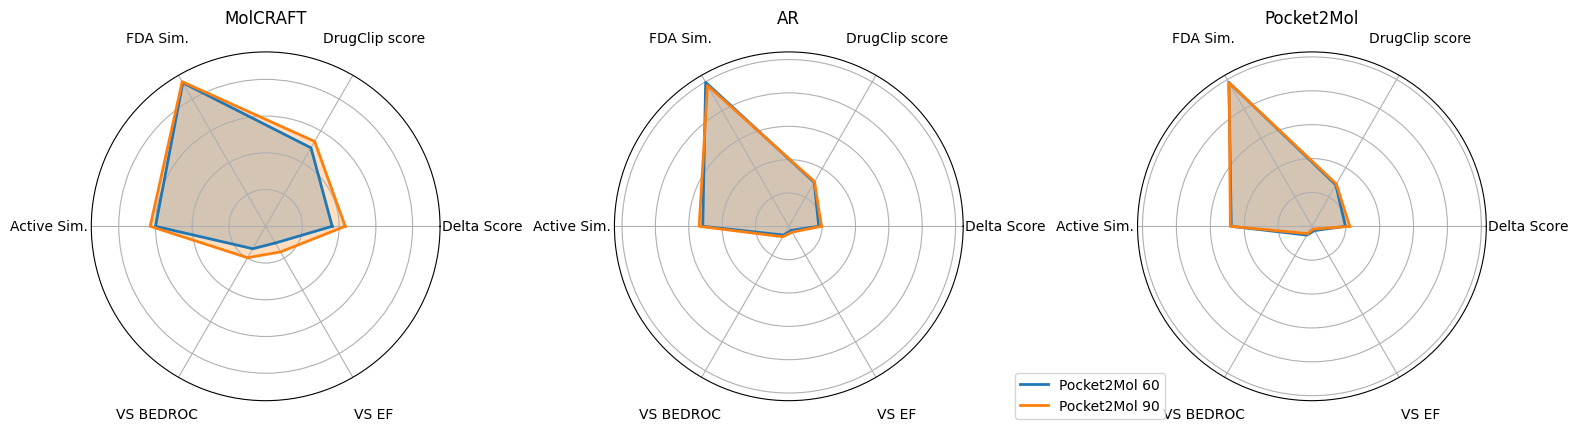

In [8]:
# draw the radar chart

import matplotlib.pyplot as plt
import numpy as np

# Metrics and data sets
labels = np.array(["Delta Score", "DrugClip score", "FDA Sim.", "Active Sim.", "VS BEDROC", "VS EF"])
# max_value= [2.686,0.473,0.749,0.870,45.43,29.23]
max_value= [2.686,0.473,0.749,0.870,45.43,29.23]
min_value= [0,-0.2,0,0,1,1]


bfn_60=[0.973, 0.132, 0.676, 0.522, 7.265, 3.968]
bfn_90=[1.163, 0.159, 0.681, 0.547, 9.782, 5.549]

AR_60=[0.483, 0.005, 0.747, 0.449, 3.698, 1.796]
AR_90=[0.523, 0.008, 0.730, 0.468, 4.223, 2.139]

Pocket2Mol_60=[0.531, -0.010, 0.735, 0.414, 3.667, 1.827]
Pocket2Mol_90=[0.599, -0.006, 0.732, 0.419, 3.215, 1.541]

Pocket2Mol_60=[0.531, -0.010, 0.735, 0.414, 3.667, 1.827]
Pocket2Mol_90=[0.599, -0.006, 0.732, 0.419, 3.215, 1.541]


bfn_60=np.array(bfn_60)
bfn_90=np.array(bfn_90)
AR_60=np.array(AR_60)
AR_90=np.array(AR_90)
Pocket2Mol_60=np.array(Pocket2Mol_60)
Pocket2Mol_90=np.array(Pocket2Mol_90)
max_value=np.array(max_value)
min_value=np.array(min_value)
# Number of variables
num_vars = len(labels)

# Adjusting normalization factors to emphasize differences between BFN 60 and BFN 90

# Increasing normalization factor differences to make the differences more pronounced
bfn_60_normalized_adjusted = (bfn_60 - min_value) / (max_value - min_value)
bfn_90_normalized_adjusted = (bfn_90 - min_value) / (max_value - min_value)
AR_60_normalized_adjusted = (AR_60 - min_value) / (max_value - min_value)
AR_90_normalized_adjusted = (AR_90 - min_value) / (max_value - min_value)
Pocket2Mol_60_normalized_adjusted = (Pocket2Mol_60 - min_value) / (max_value - min_value)
Pocket2Mol_90_normalized_adjusted = (Pocket2Mol_90 - min_value) / (max_value - min_value)

# Compute angle for each axis
angles_adjusted = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles_adjusted += angles_adjusted[:1]

# The radar chart is a circle, so we need to complete the loop
bfn_adjusted = np.vstack((bfn_60_normalized_adjusted, bfn_90_normalized_adjusted))
bfn_adjusted = np.concatenate((bfn_adjusted, bfn_adjusted[:,[0]]), axis=1)
AR_adjusted = np.vstack((AR_60_normalized_adjusted, AR_90_normalized_adjusted))
AR_adjusted = np.concatenate((AR_adjusted, AR_adjusted[:,[0]]), axis=1)
Pocket2Mol_adjusted = np.vstack((Pocket2Mol_60_normalized_adjusted, Pocket2Mol_90_normalized_adjusted))
Pocket2Mol_adjusted = np.concatenate((Pocket2Mol_adjusted, Pocket2Mol_adjusted[:,[0]]), axis=1)


# plot to a 1 line 3 column figure
fig, axs = plt.subplots(1,3,figsize=(18, 6), subplot_kw=dict(polar=True))
fig.subplots_adjust(wspace=0.5)

# Draw one axe per variable and add labels
for ax in axs:
    ax.set_xticks(angles_adjusted[:-1])
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', which='major', pad=20)
    ax.set_yticklabels([])
    # ax.set_yticks([])

# Plot data
axs[0].plot(angles_adjusted, bfn_adjusted[0], linewidth=2, linestyle='solid', label='MolCRAFT 60')
axs[0].fill(angles_adjusted, bfn_adjusted[0], alpha=0.25)
axs[0].plot(angles_adjusted, bfn_adjusted[1], linewidth=2, linestyle='solid', label='MolCRAFT 90')
axs[0].fill(angles_adjusted, bfn_adjusted[1], alpha=0.25)
axs[0].set_title("MolCRAFT")

axs[1].plot(angles_adjusted, AR_adjusted[0], linewidth=2, linestyle='solid', label='AR 60')
axs[1].fill(angles_adjusted, AR_adjusted[0], alpha=0.25)
axs[1].plot(angles_adjusted, AR_adjusted[1], linewidth=2, linestyle='solid', label='AR 90')
axs[1].fill(angles_adjusted, AR_adjusted[1], alpha=0.25)
axs[1].set_title("AR")

axs[2].plot(angles_adjusted, Pocket2Mol_adjusted[0], linewidth=2, linestyle='solid', label='Pocket2Mol 60')
axs[2].fill(angles_adjusted, Pocket2Mol_adjusted[0], alpha=0.25)
axs[2].plot(angles_adjusted, Pocket2Mol_adjusted[1], linewidth=2, linestyle='solid', label='Pocket2Mol 90')
axs[2].fill(angles_adjusted, Pocket2Mol_adjusted[1], alpha=0.25)
axs[2].set_title("Pocket2Mol")

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig("radar_chart.png",dpi=300)

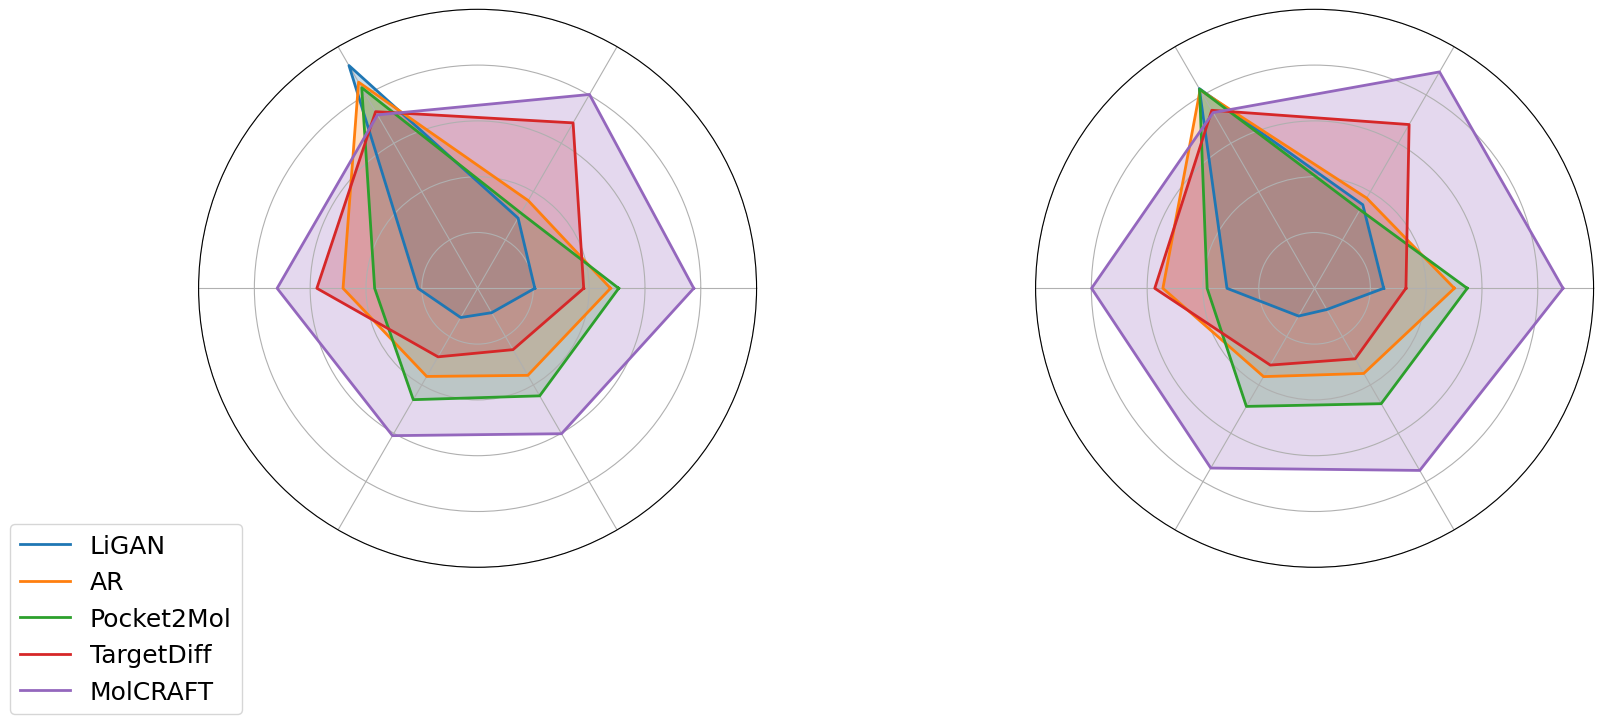

In [10]:
# draw the radar chart

from re import T
from tkinter import font
import matplotlib.pyplot as plt
import numpy as np

# Metrics and data sets
ref_value=   [2.686,0.473,0.749,0.870,39.32,24.95]
ratio=       [0.5  ,0.4  ,1.1  ,0.7  ,0.3  ,0.25  ]  
# max_value=   [1.4  ,0.2  ,0.9  ,0.6  ,12   ,7    ]
min_value=   [-0.3    ,-0.1 ,0.3  ,0.3  ,1    ,0.5    ]

labels = np.array(["Delta Score\n 50% Ref.", "DrugClip score\n40% Ref.", "FDA Sim.", "Active Sim.\n70% Ref.", "VS BEDROC\n30% Ref.", "VS EF\n25% Ref."])


LiGAN_60=     [0.037, -0.016, 0.783, 0.366, 2.306, 1.079]
LiGAN_90=     [0.107, -0.000, 0.733, 0.397, 2.240, 1.004]

AR_60=        [0.483, 0.005, 0.747, 0.449, 4.938, 2.567]
AR_90=        [0.523, 0.008, 0.730, 0.468, 4.946, 2.522]

Pocket2Mol_60=[0.531, -0.010, 0.735, 0.414, 5.976, 3.054]
Pocket2Mol_90=[0.599, -0.006, 0.732, 0.419, 6.277, 3.240]

TargetDiff_60=[0.325, 0.098, 0.683, 0.478, 4.062, 1.957]
TargetDiff_90=[0.238, 0.096, 0.686, 0.477, 4.431, 2.174]

bfn_60=       [0.973, 0.132, 0.676, 0.522, 7.584, 3.953]
bfn_90=       [1.163, 0.159, 0.681, 0.547, 9.032, 4.825]



bfn_60=np.array(bfn_60)
bfn_90=np.array(bfn_90)
AR_60=np.array(AR_60)
AR_90=np.array(AR_90)
Pocket2Mol_60=np.array(Pocket2Mol_60)
Pocket2Mol_90=np.array(Pocket2Mol_90)
TargetDiff_60=np.array(TargetDiff_60)
TargetDiff_90=np.array(TargetDiff_90)
LiGAN_60=np.array(LiGAN_60)
LiGAN_90=np.array(LiGAN_90)
# max_value=np.array(max_value)
min_value=np.array(min_value)
ref_value=np.array(ref_value)
ratio=np.array(ratio)
max_value=ref_value*ratio

# Number of variables
num_vars = len(labels)

# Adjusting normalization factors to emphasize differences between BFN 60 and BFN 90

# Increasing normalization factor differences to make the differences more pronounced
bfn_60_normalized_adjusted = (bfn_60 - min_value) / (max_value - min_value)
bfn_90_normalized_adjusted = (bfn_90 - min_value) / (max_value - min_value)
AR_60_normalized_adjusted = (AR_60 - min_value) / (max_value - min_value)
AR_90_normalized_adjusted = (AR_90 - min_value) / (max_value - min_value)
Pocket2Mol_60_normalized_adjusted = (Pocket2Mol_60 - min_value) / (max_value - min_value)
Pocket2Mol_90_normalized_adjusted = (Pocket2Mol_90 - min_value) / (max_value - min_value)
TargetDiff_60_normalized_adjusted = (TargetDiff_60 - min_value) / (max_value - min_value)
TargetDiff_90_normalized_adjusted = (TargetDiff_90 - min_value) / (max_value - min_value)
LiGAN_60_normalized_adjusted = (LiGAN_60 - min_value) / (max_value - min_value)
LiGAN_90_normalized_adjusted = (LiGAN_90 - min_value) / (max_value - min_value)

# Compute angle for each axis
angles_adjusted = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles_adjusted += angles_adjusted[:1]

# The radar chart is a circle, so we need to complete the loop
bfn_adjusted = np.vstack((bfn_60_normalized_adjusted, bfn_90_normalized_adjusted))
bfn_adjusted = np.concatenate((bfn_adjusted, bfn_adjusted[:,[0]]), axis=1)
AR_adjusted = np.vstack((AR_60_normalized_adjusted, AR_90_normalized_adjusted))
AR_adjusted = np.concatenate((AR_adjusted, AR_adjusted[:,[0]]), axis=1)
Pocket2Mol_adjusted = np.vstack((Pocket2Mol_60_normalized_adjusted, Pocket2Mol_90_normalized_adjusted))
Pocket2Mol_adjusted = np.concatenate((Pocket2Mol_adjusted, Pocket2Mol_adjusted[:,[0]]), axis=1)
TargetDiff_adjusted = np.vstack((TargetDiff_60_normalized_adjusted, TargetDiff_90_normalized_adjusted))
TargetDiff_adjusted = np.concatenate((TargetDiff_adjusted, TargetDiff_adjusted[:,[0]]), axis=1)
LiGAN_adjusted = np.vstack((LiGAN_60_normalized_adjusted, LiGAN_90_normalized_adjusted))
LiGAN_adjusted = np.concatenate((LiGAN_adjusted, LiGAN_adjusted[:,[0]]), axis=1)

# plot to a 1 line 3 column figure
fig, axs = plt.subplots(1,2,figsize=(18, 12), subplot_kw=dict(polar=True))
fig.subplots_adjust(wspace=0.5)

# Draw one axe per variable and add labels
for ax in axs:
    ax.set_xticks(angles_adjusted[:-1])
    # ax.set_xticklabels(labels, fontsize=12)
    ax.set_xticklabels([])

    ax.tick_params(axis='x', which='major', pad=25)
    ax.set_ylim(0, 1)
    ax.set_yticklabels([])
    # ax.set_yticks([])

# Plot data
axs[0].plot(angles_adjusted, LiGAN_adjusted[0], linewidth=2, linestyle='solid', label='LiGAN')
axs[0].fill(angles_adjusted, LiGAN_adjusted[0], alpha=0.25)
axs[0].plot(angles_adjusted, AR_adjusted[0], linewidth=2, linestyle='solid', label='AR')
axs[0].fill(angles_adjusted, AR_adjusted[0], alpha=0.25)
axs[0].plot(angles_adjusted, Pocket2Mol_adjusted[0], linewidth=2, linestyle='solid', label='Pocket2Mol')
axs[0].fill(angles_adjusted, Pocket2Mol_adjusted[0], alpha=0.25)
axs[0].plot(angles_adjusted, TargetDiff_adjusted[0], linewidth=2, linestyle='solid', label='TargetDiff')
axs[0].fill(angles_adjusted, TargetDiff_adjusted[0], alpha=0.25)
axs[0].plot(angles_adjusted, bfn_adjusted[0], linewidth=2, linestyle='solid', label='MolCRAFT')
axs[0].fill(angles_adjusted, bfn_adjusted[0], alpha=0.25)
# axs[0].set_title("FLAPP 0.6 split")


axs[1].plot(angles_adjusted, LiGAN_adjusted[1], linewidth=2, linestyle='solid', label='LiGAN')
axs[1].fill(angles_adjusted, LiGAN_adjusted[1], alpha=0.25)
axs[1].plot(angles_adjusted, AR_adjusted[1], linewidth=2, linestyle='solid', label='AR')
axs[1].fill(angles_adjusted, AR_adjusted[1], alpha=0.25)
axs[1].plot(angles_adjusted, Pocket2Mol_adjusted[1], linewidth=2, linestyle='solid', label='Pocket2Mol')
axs[1].fill(angles_adjusted, Pocket2Mol_adjusted[1], alpha=0.25)
axs[1].plot(angles_adjusted, TargetDiff_adjusted[1], linewidth=2, linestyle='solid', label='TargetDiff')
axs[1].fill(angles_adjusted, TargetDiff_adjusted[1], alpha=0.25)
axs[1].plot(angles_adjusted, bfn_adjusted[1], linewidth=2, linestyle='solid', label='MolCRAFT')
axs[1].fill(angles_adjusted, bfn_adjusted[1], alpha=0.25)
# axs[1].set_title("FLAPP 0.9 split")


axs[0].legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),fontsize =18)
# axs[1].legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig("radar_chart.png",dpi=300)

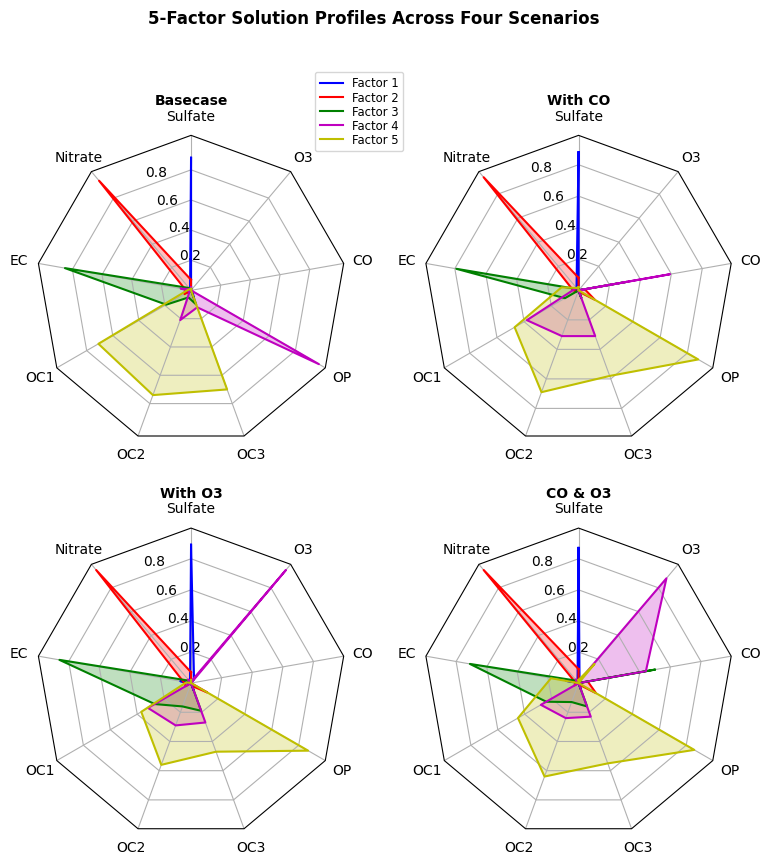

In [2]:
"""
======================================
Radar chart (aka spider or star chart)
======================================

This example creates a radar chart, also known as a spider or star chart [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
`matplotlib.axis` to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axis.

.. [1] https://en.wikipedia.org/wiki/Radar_chart
"""

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate Axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()


# %%
#
# .. admonition:: References
#
#    The use of the following functions, methods, classes and modules is shown
#    in this example:
#
#    - `matplotlib.path`
#    - `matplotlib.path.Path`
#    - `matplotlib.spines`
#    - `matplotlib.spines.Spine`
#    - `matplotlib.projections`
#    - `matplotlib.projections.polar`
#    - `matplotlib.projections.polar.PolarAxes`
#    - `matplotlib.projections.register_projection`
